<a href="https://colab.research.google.com/github/GianEscher/quantum-lab-finance/blob/main/QAOA_estudo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Estudo de implementação do algoritmo QAOA de otimização de portfolios</h1>

O presente caderno de códigos contém duas implementações do QAOA: 
- A versão elaborada via ChatGPT (Não-funcional)
- O algoritmo de otimização QAOA modificado (funcional)

Segue abaixo a instalação das bibliotecas necessárias e o script elaborado via ChatGPT:



In [ ]:
!pip install qiskit
!pip install qiskit-finance

In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
from qiskit.finance.applications.ising import portfolio

from qiskit import Aer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.components.optimizers import COBYLA

yf.pdr_override()

# Defina os ativos para os quais queremos os dados
assets = ['AAPL', 'MSFT', 'GOOG', 'FB', 'AMZN']

# Defina o intervalo de datas para o qual queremos os dados
start_date = '2020-01-01'
end_date = '2021-12-31'

# Obtenha os dados do Yahoo Finance
data = pdr.get_data_yahoo(assets, start=start_date, end=end_date)

# Use apenas o preço de fechamento
data = data['Close']

# Calcule os retornos logarítmicos, que são mais apropriados para a análise financeira
returns = np.log(data / data.shift(1))

# Calcule os retornos médios e a matriz de covariância
mu = returns.mean().values

# Generate expected return and covariance matrix from (random) time-series
sigma = returns.cov().values

# Defina o orçamento
budget = 2

# Crie uma instância do problema de otimização de portfólio
portfolio = portfolio.Portfolio(expected_returns=mu, covariances=sigma, budget=budget) PROVAVELMENTE DEPRECIADO

print("RETORNOS")
print(returns)

print("PORTFOLIO")
print(portfolio)

# Crie uma instância do algoritmo QAOA
#qaoa = QAOA(optimizer=COBYLA(), quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
#SUPOSTAMENTE DEPRECIADA - LER O BLOCO DE TEXO ABAIXO!

# Execute o algoritmo QAOA para encontrar a solução ótima
#result = qaoa.compute_minimum_eigenvalue(qubit_op)

# Print the result
#print(result)

#Etapa de análise

A abordagem utilizada para detecção de erros no primeiro código foi por meio da análise do fluxo de dados do algoritmo.

A primeira anomalia encontrada estava nos imports gerados. Constatou-se que o framework utilizado, AQUA (Advanced Quantum Architecture), está depreciado desde 2 de abril de 2021, a partir da versão 0.9.0 (Repositório Qiskit Aqua. **Github** ,2019)

<a href="https://github.com/qiskit-community/qiskit-aqua
" target="_blank"> Repositório Qiskit Aqua</a>

<h1>Atualização das bibliotecas</h1>

De acordo com a documentação oficial de  <a href="https://github.com/qiskit-community/qiskit-aqua/blob/main/docs/tutorials/Qiskit%20Algorithms%20Migration%20Guide.ipynb
" target="_blank"> migração de algoritmos Qiskit</a>, as seguintes atualizações foram feitas:

>**Quantum instance**




In [ ]:
#antes
from qiskit.aqua import QuantumInstance

#atual
from qiskit.utils import QuantumInstance

>**Otimizadores**

In [ ]:
#antes
from qiskit.aqua.components.optimizers import COBYLA

#atual
from qiskit.algorithms.optimizers import COBYLA

>**Algorítmos**

In [ ]:
#antes
from qiskit.aqua.algorithms import QAOA

#atual
from qiskit.algorithms.minimum_eigensolvers import QAOA

#Construção do portfólio para análise

Ainda na atualização de importações, constatou-se que o acesso "qiskit.finance" também está depreciado, ao que a documentação oficial para o <a href="https://qiskit.org/ecosystem/finance/tutorials/01_portfolio_optimization.html
" target="_blank"> qiskit-finance 0.3.4</a> utiliza "qiskit_finance" para importar o módulo "PortfolioOptimization". Isso também implica na mudança na construção do objeto portfolio, como é demonstrado abaixo.


In [ ]:
#antes
from qiskit.finance.applications.ising import portfolio
#e
portfolio = portfolio.Portfolio(expected_returns=mu, covariances=sigma, budget=budget)

#depois
from qiskit_finance.applications.optimization import PortfolioOptimization
#e
q = float(0.5)#Fator de risco deve ser adicionado para nova implementação
portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget)


#Símbolo de ativo desatualizado

Como pode ser observado no algoritmo gerado por ChatGPT, os ativos utilizados de exemplo para a otimização de portfólio incluem as bigtechs Google, Microsoft, Apple, Facebook e Amazon. Observou-se, no entanto, que havia uma série indesejada de NaN sendo recuperada juntamente das demais séries históricas

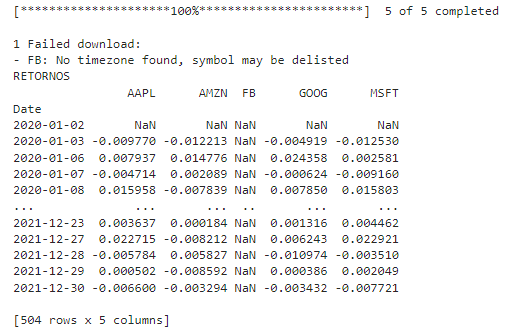

Após substituir o símbolo 'FB' por 'META', o problema foi solucionado

#Cálculo dos ganhos diários

Duas opções foram consideradas para o cálculo dos ganhos diários de cada ativo:
- Erro percentual de cada registro
- Retorno logaritimico



A implementação abaixo faz uso de erro percentual, conforme fora desenvolvido previamente para a implementação clássica da otimização de Markowitz:


In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt

from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit_aer.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

yf.pdr_override()

# Defina os ativos para os quais queremos os dados
assets = ['AAPL', 'MSFT', 'META', 'GOOG', 'AMZN']#ChatGpt utilizou FB ao invés de META - gerando séries de 'nan'

# Defina o intervalo de datas para o qual queremos os dados
start_date = '2022-12-01'
end_date = '2022-12-31'

# Obtenha os dados do Yahoo Finance
data_raw = pdr.DataReader(assets, start=start_date, end=end_date)

# Use apenas o preço de fechamento
data = []
data = data_raw['Close']

#o laço while abaixo calcula os erros percentuais consecutivos
returns_dictio = {}
i = 0
while(i<len(assets)):
  j=1
  stocks_registry = []
  key = assets[i]
  while(j<len(data[key])):
    stocks_registry.append((data[key][j]-data[key][j-1])/data[key][j-1])
    j+=1
  returns_dictio[key] = stocks_registry
  i +=1

returns = pd.DataFrame(returns_dictio)
print(returns)

# Calcule os retornos médios e a matriz de covariância!!!!!
mu = returns.mean().values
sigma = returns.cov().values

print(mu)
print(sigma)

# Defina o orçamento
budget = 2

# Crie uma instância do problema de otimização de portfólio
q = float(0.5)

portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget)
qp = portfolio.to_quadratic_program()

Define uma função para exibição dos resultados. Retirada da  documentação <a href="https://qiskit.org/ecosystem/finance/tutorials/01_portfolio_optimization.html
" target="_blank"> otimização de portfólios com qiskit-finance 0.3.4</a>



In [20]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

Solução com QAOA e COBYLA. Retirada da  documentação <a href="https://qiskit.org/ecosystem/finance/tutorials/01_portfolio_optimization.html
" target="_blank"> otimização de portfólios com qiskit-finance 0.3.4</a>

In [25]:
#algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [0. 0. 0. 1. 1.], value 0.0039

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 0 0 1]	0.0102		0.0928
[1 0 0 1 0]	0.0076		0.0918
[1 0 1 0 0]	0.0138		0.0898
[0 1 0 1 0]	0.0076		0.0869
[0 1 1 0 0]	0.0137		0.0830
[0 1 0 0 1]	0.0101		0.0801
[0 0 1 0 1]	0.0102		0.0791
[0 0 0 1 1]	0.0039		0.0791
[0 0 1 1 0]	0.0077		0.0791
[1 1 0 0 0]	0.0138		0.0732
[0 0 0 1 0]	0.0005		0.0215
[0 0 1 0 0]	0.0068		0.0166
[0 0 0 0 1]	0.0031		0.0156
[0 1 0 0 0]	0.0067		0.0146
[1 0 0 0 0]	0.0068		0.0137
[0 0 1 1 1]	0.0114		0.0117
[0 0 0 0 0]	0.0000		0.0117
[0 1 1 1 0]	0.0151		0.0068
[1 0 0 1 1]	0.0114		0.0068
[1 0 1 1 0]	0.0151		0.0068
[0 1 1 0 1]	0.0174		0.0059
[1 1 1 0 0]	0.0211		0.0059
[1 1 0 0 1]	0.0175		0.0049
[1 1 1 1 1]	0.0271		0.0039
[1 0 1 0 1]	0.0175		0.0039
[0 1 0 1 1]	0.0114		0.0029
[1 1 0 1 0]	0.0151		0.0029
[0 1 1 1 1]	0.0191		0.0029
[1 1 1 0 1]	0.0251		0.0020
[1 1 1 1 0]	0.0228		0.0020
[1 0 1

#Ganhos diários logaritimicos com séries de dados aleatórios

A implementação a seguir é idêntica à abordagem anterior, substituindo apenas as séries históricas de ativos por séries de números aleatórios, bem como o cálculo de erros percentuais por ganho logaritimico.
 Os trechos mencionados foram retirados da  documentação <a href="https://qiskit.org/ecosystem/finance/tutorials/01_portfolio_optimization.html
" target="_blank"> otimização de portfólios com qiskit-finance 0.3.4</a>




In [46]:
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit_aer.primitives import Sampler
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime

# set number of assets (= number of qubits)
num_assets = 4
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()



In [47]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()

In [48]:
cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0149

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0149		0.1641
 [1 1 0 0]	-0.0130		0.1562
 [0 0 1 1]	-0.0010		0.1533
 [0 1 0 1]	0.0002		0.1504
 [0 1 1 0]	0.0008		0.1396
 [1 0 1 0]	-0.0140		0.1328
 [1 1 0 1]	-0.0139		0.0195
 [1 0 1 1]	-0.0150		0.0176
 [1 1 1 0]	-0.0130		0.0156
 [1 0 0 0]	-0.0140		0.0156
 [0 1 1 1]	-0.0000		0.0127
 [1 1 1 1]	-0.0139		0.0088
 [0 0 0 1]	-0.0008		0.0088
 [0 1 0 0]	0.0009		0.0020
 [0 0 1 0]	-0.0001		0.0020
 [0 0 0 0]	0.0000		0.0010
